In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
sns.set(style="whitegrid")
from pySankey import sankey
import plotly.graph_objects as go
#pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
df = pd.read_csv('dataTP1.csv')

In [3]:
df.columns

Index(['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval',
       'Bureaucratic_Code', 'Account_Created_Date', 'Source ',
       'Billing_Country', 'Account_Name', 'Opportunity_Name', 'Opportunity_ID',
       'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner',
       'Account_Type', 'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Last_Activity',
       'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By',
       'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP',
       'ASP_(converted)_Currency', 'ASP_(converted)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'Actual_Delivery_Date', 'TRF',
       'Total_Amount_Currenc

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16499 entries, 0 to 16498
Data columns (total 54 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  16499 non-null  int64  
 1   Region                              16499 non-null  object 
 2   Territory                           16499 non-null  object 
 3   Pricing, Delivery_Terms_Quote_Appr  16499 non-null  int64  
 4   Pricing, Delivery_Terms_Approved    16499 non-null  int64  
 5   Bureaucratic_Code_0_Approval        16499 non-null  int64  
 6   Bureaucratic_Code_0_Approved        16499 non-null  int64  
 7   Submitted_for_Approval              16499 non-null  int64  
 8   Bureaucratic_Code                   16499 non-null  object 
 9   Account_Created_Date                16499 non-null  object 
 10  Source                              16499 non-null  object 
 11  Billing_Country                     16499

In [6]:
df['Opportunity_Created_Date']=pd.to_datetime(df['Opportunity_Created_Date'])

In [8]:
len(set(df.Opportunity_Name))

9791

In [5]:
#Como cada Oportunidad puede tener varios ítems asociados (registros).Para el análisis de Regiones y Territorios como lo hacemos para cada oportunidad, 
#puedo agrupar por oportunidad o quedarme con el dato de la region y territorio de una de ellas directamente (ej,tomo la primera) 
df_op =df.drop_duplicates(subset='Opportunity_Name',keep='first')

In [9]:
df_op[['ID','Opportunity_ID','Opportunity_Name','Region','Territory']].head(10)

,ID,Opportunity_ID,Opportunity_Name,Region,Territory
0,27761,0,Opportunity_Name_12598,Europa,None
1,27760,1,Opportunity_Name_12600,Europa,None
2,27446,2,Opportunity_Name_469,América,NW America
3,16808,3,Opportunity_Name_415,América,NW America
4,16805,4,Opportunity_Name_851,América,NW America
5,16802,5,Opportunity_Name_939,América,NW America
6,16799,6,Opportunity_Name_1618,América,NW America
7,27455,7,Opportunity_Name_8227,América,NW America
8,24353,8,Opportunity_Name_6151,Asia-Pacífico,Japan
13,24420,9,Opportunity_Name_6817,Asia-Pacífico,Japan


## 1. Stage

* Stage es nuestra variable target, variable que nos indica el estado de la oportunidad, o sea si la oportunidad resultó en éxito o no (closed won o closed lost respectivamente).

In [7]:
# Veamos sus valores únicos y cantidades
df_op['Stage'].value_counts()

Closed Won       5072
Closed Lost      4719
Proposal           30
Negotiation        11
Qualification       9
Name: Stage, dtype: int64

* Se observa en dicha variable que, además de los estados que indican si una oportunidad resultó exitosa o no (**estados finales**), tenemos otros 3 estados (Proposal, Negotiation y Qualification) que corresponden a **estados intermedios** que tienen las oportunidades dentro del pipeline que desarrolla la empresa.

* Como con esta variable se estará luego tratando de predecir la “Probabilidad de éxito” para cada oportunidad, o sea ¿Cuál es la probabilidad de que la oportunidad se convierta en un caso Closed Won? .Que decisión debemos tomar con dichos estados? Dichos estados al no tener una resolución, debemos asignarle arbitrariamente algún estado final? Debemos filtrar estos casos?

> Luego de analizar esos registros con estos estados intermedios y verificar que corresponen a oportunidades que no tuvieron aún en desenlase exitoso o no y tenindo en cuenta que corresponden a unos pocos casos, tomamos la decisión de filtrar estos registros y quedarnos solamente con los que tienen un estado final definido.

In [8]:
df_op= df_op.loc[(df['Stage']!='Proposal') & (df['Stage']!='Negotiation') & (df['Stage']!='Qualification'),:]

#### En nuestro set de datos: ¿Cuántas oportunidades resultaron exitosas y cuantas no lo fueron?

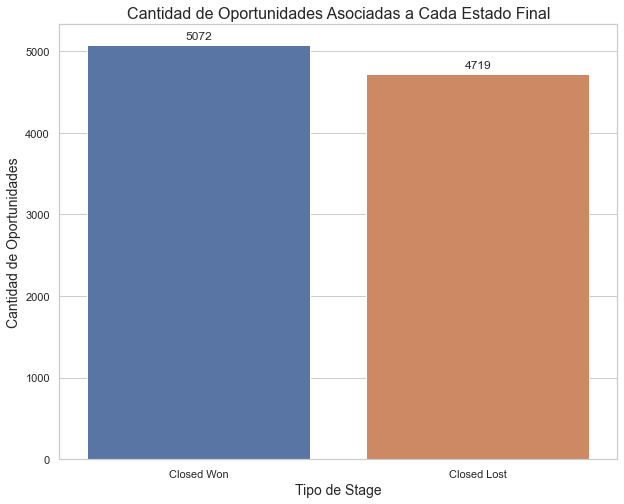

In [13]:
target = df_op['Stage'].value_counts()
plt.subplots(figsize=(10,8))
grafico_top7=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico_top7.patches:
    grafico_top7.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico_top7.set_title("Cantidad de Oportunidades Asociadas a Cada Estado Final",fontsize=16)
grafico_top7.set_ylabel("Cantidad de Oportunidades",fontsize=14)
grafico_top7.set_xlabel("Tipo de Stage",fontsize=14);
plt.savefig('graficos/1.png')

In [14]:
df_op['Stage'].value_counts(normalize=True)

Closed Won     0.518027
Closed Lost    0.481973
Name: Stage, dtype: float64

* En esta visualización se puede ver como queda definida la cantidad de oportunidades según el estado final (Closed Won y Closed Lost). Se observa que en el set de datos predominan las oportunidades que resultaron exitosas con 5072 casos (51.8%) frente a las No exitosas con 4719 casos (48.2%)


## 2. Región:

#### ¿Cuántas rigiones distintas tenemos en nuestro set de datos y como se distribuyen las cantidasdes de Oportunidades en las mismas?

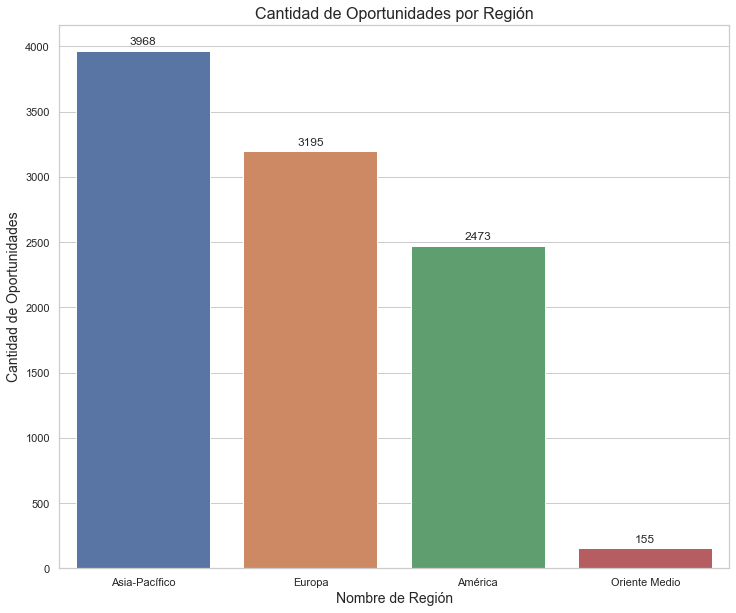

In [15]:
target = df_op['Region'].value_counts()
plt.subplots(figsize=(12,10))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Cantidad de Oportunidades por Región",fontsize=16)
grafico.set_ylabel("Cantidad de Oportunidades",fontsize=14)
grafico.set_xlabel("Nombre de Región",fontsize=14);
plt.savefig('graficos/2.png')

* Como se puede ver la Región Asia-Pacífico es la predominante con 3968 oportunidades, es importante destacar que el valor alcanzado por esta Región, tiene mucho que ver con lo realizado en el preprocesamiento de los datos. A esta Región se le asignó Japón como territorio perteneciente. Este dato no es menor ya que Japón representa el 48% del total de oportunidades de la Región Asia-Pacífico y un 19% del total de oportunidades globales. Las Regiones que le siguen son Europa y América en cantidad de oportunidades con valores 3195 y 2473 respectivamente. Finalmente Oriente Medio es la región que presenta menos oportunidades para la empresa con solamente 155.

In [16]:
df_op.loc[df['Region']=='Asia-Pacífico',:]['Territory'].value_counts(normalize=True).head()

Japan        0.475050
India        0.170867
Australia    0.145413
Singapore    0.073841
Thailand     0.037046
Name: Territory, dtype: float64

In [17]:
df_op['Territory'].value_counts(normalize=True).head()

Japan         0.192524
Germany       0.110305
NW America    0.089266
India         0.069247
Australia     0.058932
Name: Territory, dtype: float64

#### ¿Cómo se distribuyen las oportunidades exitosas y no exitosas según las distintas Regiones?

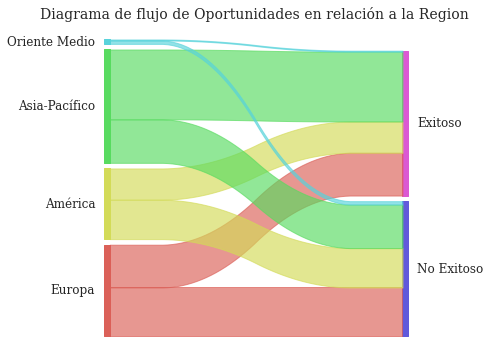

In [18]:
df_op['Oportunidad']= '' 
df_op.loc[df_op['Stage']== 'Closed Won','Oportunidad']= 'Exitoso'
df_op.loc[df_op['Stage']== 'Closed Lost','Oportunidad']= 'No Exitoso'
sankey.sankey(df_op['Region'],df_op['Oportunidad'],aspect=20, fontsize=12)
plt.title('Diagrama de flujo de Oportunidades en relación a la Region ',fontsize=14);
plt.savefig('graficos/3.png')

* Asia-Pacífico, que como vimos es la Región que más oportunidades presenta y también es la que mayor casos Exitosos tiene como era de esperar, pero notamos que su flujo hacia los casos Exitosos es mayor que a los No Exitosos, mientras que las demás Regiones a simple vista presentan una distribución bastante similar hacia casos Exitosos y No Exitosos.

#### Si quiero cuantificar esas distribuciones de Oportunidades en Exitosas o No Exitosas según cada Región. ¿Cuáles son esas cantidades?

In [19]:
df_op['veces'] = 1
mi_map=pd.crosstab(df_op['Region'], df_op['Stage'],values=df_op.veces,aggfunc=np.sum)

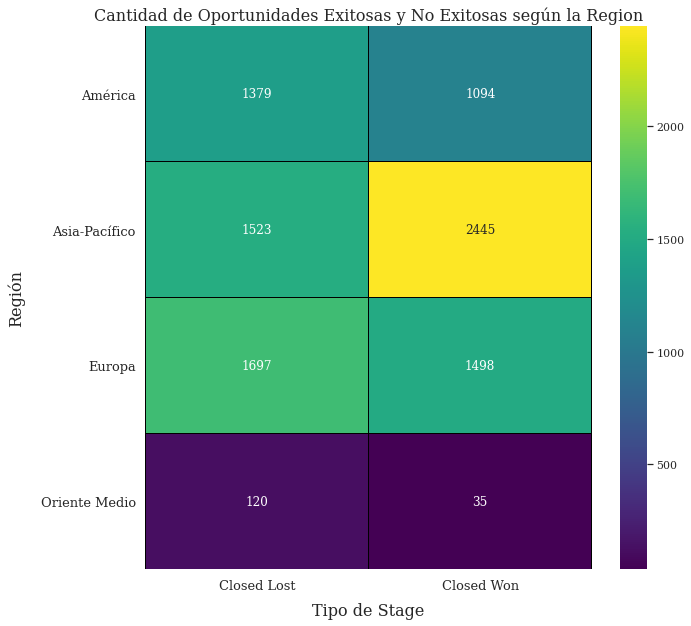

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
g = sns.heatmap(mi_map, cmap="viridis", ax=ax, linewidths=0.005, linecolor='black',annot=True,fmt='g')
g.set_title("Cantidad de Oportunidades Exitosas y No Exitosas según la Region", fontsize=16)
g.set_xlabel("Tipo de Stage", fontsize=16, labelpad=10)
g.set_ylabel("Región", fontsize=16, labelpad=16, rotation=90)
g.set_xticklabels(g.get_xticklabels(), fontsize=13)
g.set_yticklabels(g.get_yticklabels(), fontsize=13, rotation=0)
g.title.set_position([0.5, 1.05]);
plt.savefig('graficos/4.png');
plt.show();

* Al cuantificar los valores de casos Exitosos y No Exitosos asociados a cada región podemos ver varias cosas interesantes. Para Asia-Pacífico, no sólo las cantidades exitosas son mayores a las no exitosas sino que representan una alta cantidad del total de oportunidades de dicha región, más precisamente un 62%. Europa contrariamente presenta mayor cantidad de oportunidades fracasadas en relación a su total de oportunidades (1498 casos exitosos frente a 1697 no exitosos) un 53% aproximadamente. Para las dos Regiones restantes (América y Oriente Medio) los casos no exitosos también son los que predominan en el total de oportunidades de dichas regiones.

#### ¿Cómo es la evolución anual de la cantidad de Oportunidades según la Región?

In [21]:
df_op['Año_Oportunidad']=df_op['Opportunity_Created_Date'].dt.year

In [22]:
df_op['Opportunity_Created_Date'].nlargest(3)

15653   2018-12-29
15652   2018-12-28
15651   2018-12-26
Name: Opportunity_Created_Date, dtype: datetime64[ns]

In [23]:
df_op['Opportunity_Created_Date'].nsmallest(3)

15656   2013-11-05
15657   2014-03-21
15658   2014-03-28
Name: Opportunity_Created_Date, dtype: datetime64[ns]

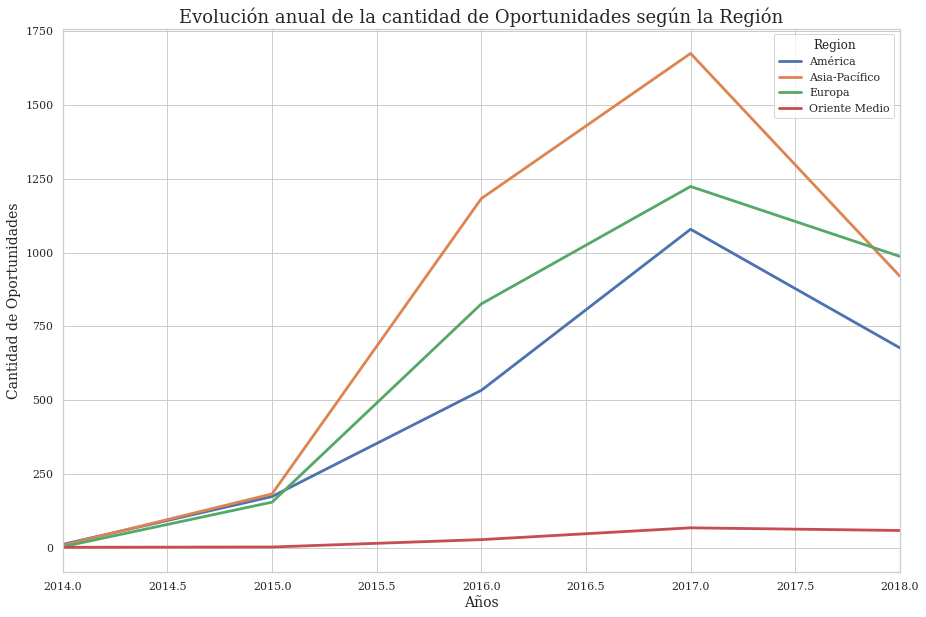

In [24]:
grafico=pd.crosstab(df_op['Año_Oportunidad'],df_op['Region']).plot(figsize=(15,10),linewidth=2.8);
grafico.set_title("Evolución anual de la cantidad de Oportunidades según la Región",fontsize=18)
plt.xlim(2014,2018)
grafico.set_xlabel("Años",fontsize=14)
grafico.set_ylabel("Cantidad de Oportunidades",fontsize=14);
plt.savefig('graficos/5.png');

* Oriente Medio en general presenta un comportamiento prácticamente constante con muy bajas cantidades de oportunidades, las cuales tuvieron un tenue incremento entre 2016 y 2017.

* Las regiones América, Europa y Asia-Pacífico de 2014 a 2015 notamos que presentan un incremento en cantidad de oportunidades. Asia-Pacífico presenta un marcado incremento (mayor pendiente) que las dos primeras. América y Europa en este período tienen una pendiente similar, con la primera Región levemente por encima de la segunda.

* Asia-Pacífico continúa con el crecimiento en cantidad de oportunidades de 2015 a 2017 siendo más notorio su incremento en el período 2015-2016 que en 2016-2017. Luego de 2017 a 2018 ocurre una brusca caída, terminando con cantidades inferiores a Europa.

* América y Europa también continúan con el crecimiento en cantidad de oportunidades de 2015 a 2017 pero ésta última supera a la primera antes de la mitad del 2015 con una pendiente positiva constante hasta el 2017. América por su lado de 2015 a 2016 tuvo una menor pendiente positiva pero de 2016 a 2017 muestra una mayor recuperación. Luego, de 2017 al 2018 ambas Regiones presentan pendiente negativas denotando caídas en las oportunidades, aunque no tan bruscas como Asia-Pacífico.


## 3. Hemisferio

#### ¿Cómo se distribuyen las oportunidades exitosas y no exitosas según los distintas Hemisferios?

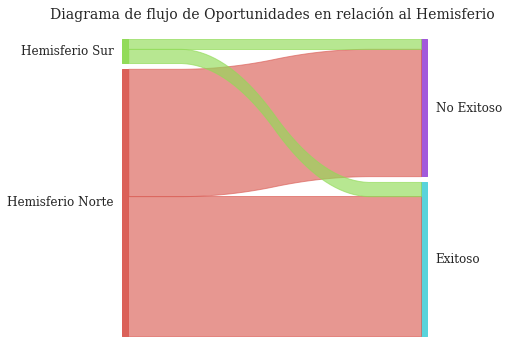

In [25]:
# Filtro primeramente los valores correspondiente a los 2 Hemisferios con los que cuento información(filtro casos nulos)
hemisferios = df_op.loc[df_op['Hemisferio']!='None',:].copy()
sankey.sankey(hemisferios['Hemisferio'],hemisferios['Oportunidad'],aspect=20, fontsize=12)
plt.title('Diagrama de flujo de Oportunidades en relación al Hemisferio ',fontsize=14);
plt.savefig('graficos/6.png');

* Tomando los hemisferios norte y sur,  se puede observar a simple vista que el caudal mayor por una diferencia importante es de oportunidades realizadas en el hemisferio norte, donde la diferencia entre las oportunidades que se realizaron con éxito y las que fracasaron es muy similar. De forma similar, en una proporción mucho menor, en el hemisferio sur se puede observar a simple vista que la relación entre éxito/fracaso es muy similar, aunque se nota que las operaciones exitosas son las que predominaron.

#### Si quiero cuantificar esas distribuciones de Oportunidades en Exitosas o No Exitosas según cada Hemisferio. ¿Cuáles son esas cantidades?

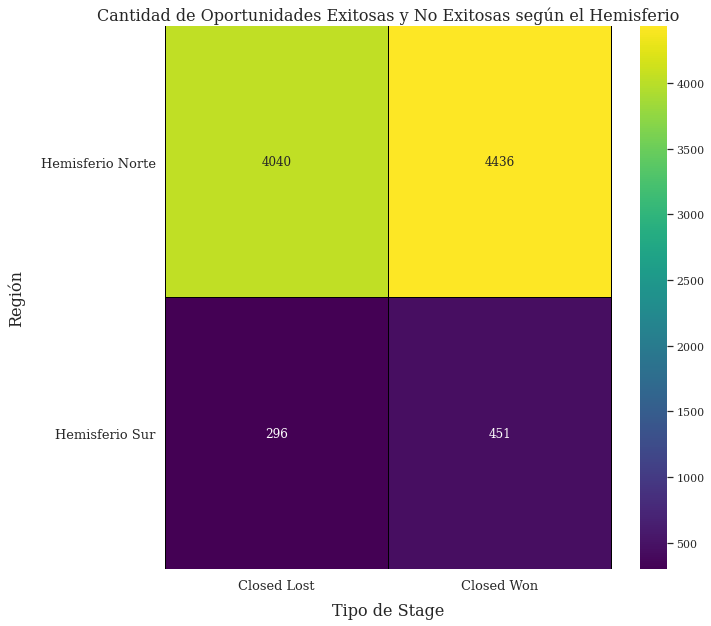

In [26]:
hemisferios['veces'] = 1
mi_map=pd.crosstab(hemisferios['Hemisferio'], hemisferios['Stage'],values=hemisferios.veces,aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(10,10))
g = sns.heatmap(mi_map, cmap="viridis", ax=ax, linewidths=0.005, linecolor='black',annot=True,fmt='g')
g.set_title("Cantidad de Oportunidades Exitosas y No Exitosas según el Hemisferio", fontsize=16)
g.set_xlabel("Tipo de Stage", fontsize=16, labelpad=10)
g.set_ylabel("Región", fontsize=16, labelpad=16, rotation=90)
g.set_xticklabels(g.get_xticklabels(), fontsize=13)
g.set_yticklabels(g.get_yticklabels(), fontsize=13, rotation=0)
g.title.set_position([0.5, 1.05]);
plt.savefig('graficos/7.png');
plt.show()

* Del mismo modo que se visualizaba en el gráfico anterior, ahora podemos visualizar con un heap map y tener una mayor noción de las cantidades. Se puede observar que para ambos hemisferios la cantidad de operaciones fracasadas resultó menor que la cantidad de operaciones exitosas.

## 4. Territorios

#### ¿Cuáles son los 7 Territorios más populares para cada Región?

In [27]:
df_territorio=df_op[['Territory','Stage','Region']].copy()
df_territorio['veces'] = 1
df_territorio = df_territorio.loc[df_territorio['Territory']!='None',:]
america = df_territorio.loc[df_territorio['Region']=='América',['Territory']]
europa = df_territorio.loc[df_territorio['Region']=='Europa',['Territory']]
oriente_medio = df_territorio.loc[df_territorio['Region']=='Oriente Medio',['Territory']]
asia_pacifico = df_territorio.loc[df_territorio['Region']=='Asia-Pacífico',['Territory']]

In [28]:
america['Territory'].value_counts(normalize=True).head(7)

NW America    0.420192
NE America    0.249038
SE America    0.162019
Central US    0.069712
SW America    0.050000
Canada        0.029327
Carribean     0.012981
Name: Territory, dtype: float64

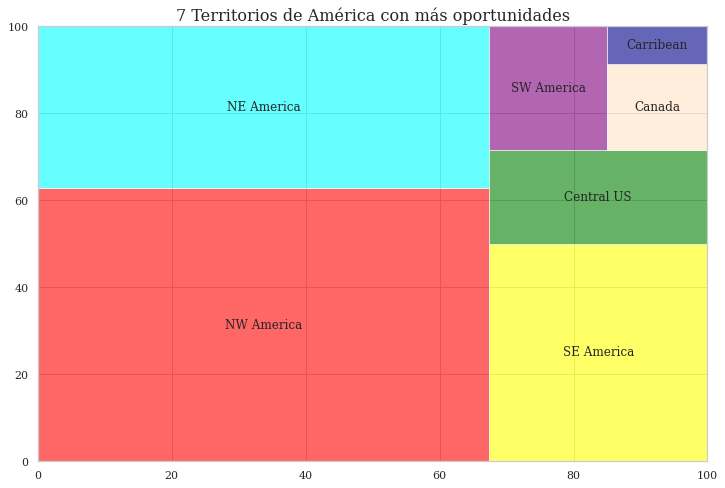

In [29]:
territorios = america['Territory'].value_counts()
data = territorios.head(7)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
visu = squarify.plot(data, label=data.index, alpha=.6,color=['red','cyan','yellow','green','purple','bisque','darkblue'],)
visu.set_title('7 Territorios de América con más oportunidades',fontsize=16);
plt.savefig('graficos/8.png');

* Comencemos por la región de América. En este gráfico Treemap notamos a simple vista el caudal de oportunidades realizadas en los 7 territorios más populares de la región. Se puede observar que el mayor porcentaje lo tiene NW America seguido de NE America, entre ambos territorios tenemos concentrado casi el 70% de las oportunidades del top7. También destacamos a SE America que del 30% restante ocupa un 15%.

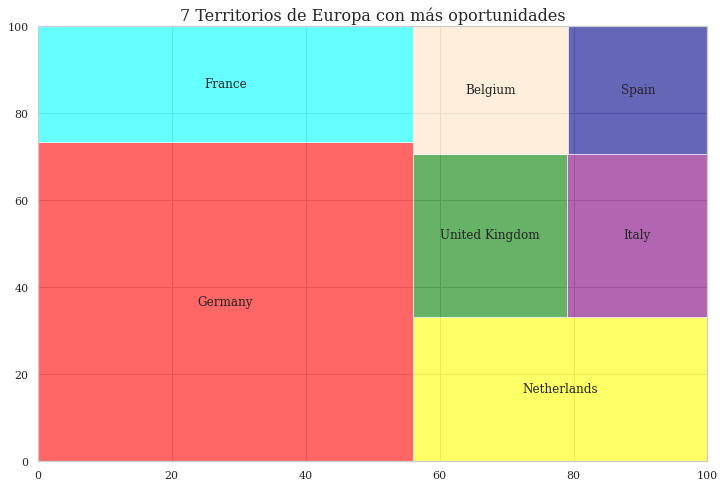

In [30]:
territorios = europa['Territory'].value_counts()
data = territorios.head(7)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
visu = squarify.plot(data, label=data.index, alpha=.6,color=['red','cyan','yellow','green','purple','bisque','darkblue'],)
visu.set_title('7 Territorios de Europa con más oportunidades',fontsize=16);
plt.savefig('graficos/9.png');

* En Europa podemos destacar a Germany claramente como el más popular abarcando aproximadamente el 45% de las oportunidades. Del 55% restante tenemos que las proporciones de Netherlands y Francia abarcan aproximadamente un 27,5% (la mitad de 55%) y los 4 territorios restantes del top 7 de esta región se reparten el otro 27,5% en similares proporciones.

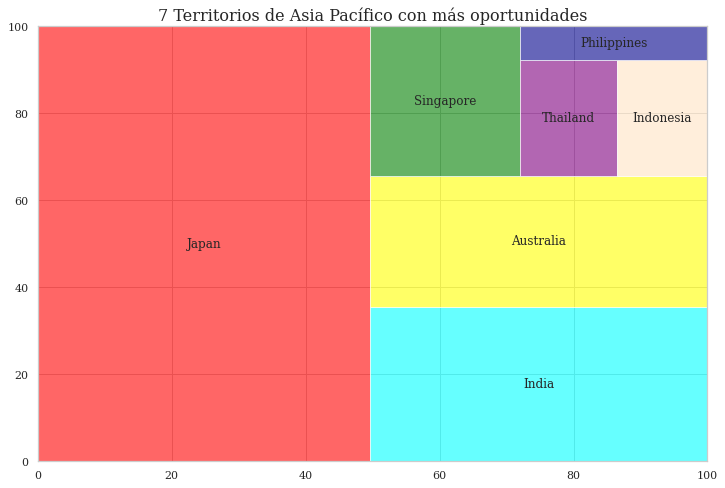

In [31]:
territorios = asia_pacifico['Territory'].value_counts()
data = territorios.head(7)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
visu = squarify.plot(data, label=data.index, alpha=.6,color=['red','cyan','yellow','green','purple','bisque','darkblue'],)
visu.set_title('7 Territorios de Asia Pacífico con más oportunidades',fontsize=16);
plt.savefig('graficos/10.png');

* En la región de Asia Pacífico podemos observar que Japón es el claro dominante en cantidad de oportunidades con un porcentaje aproximado del 50%. Del 50% restante, presentan un gran caudal India y Australia ocupando aproximadamente un 33%. El 17% restante se distribuye entre Singapore, Indonesia, Thailand y Philippines.

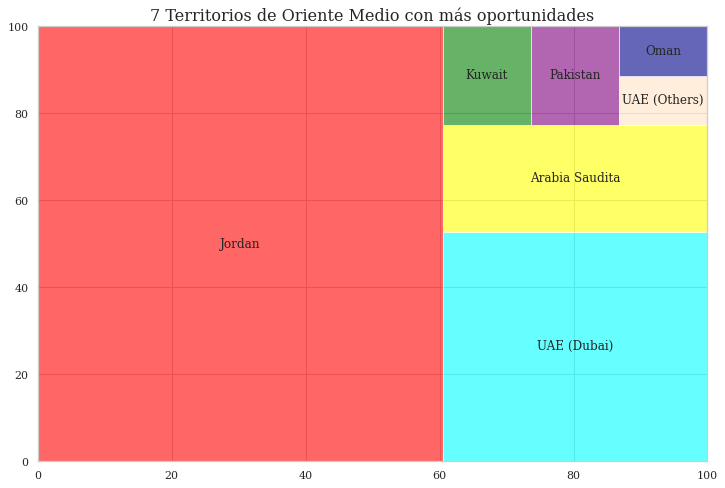

In [32]:
territorios = oriente_medio['Territory'].value_counts()
data = territorios.head(7)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
visu = squarify.plot(data, label=data.index, alpha=.6,color=['red','cyan','yellow','green','purple','bisque','darkblue'],)
visu.set_title('7 Territorios de Oriente Medio con más oportunidades',fontsize=16);
plt.savefig('graficos/11.png');

* En Oriente medio tenemos a Jordan claramente como el más popular abarcando algo más del 60% de las oportunidades, seguido por Dubai por un 20% aproximadamente, y el tercero más popular siendo Arabia Saudita con un 10% aproximado.

#### Independientemente de la Región. ¿Cuál es el Top 7 Territorios más populares y sus correspondientes cantidades de Oportunidades?

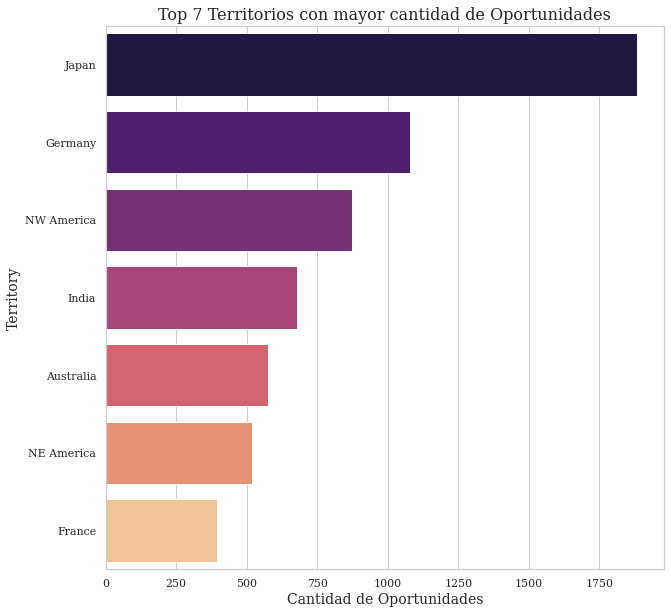

In [33]:
target = df_territorio['Territory'].value_counts().nlargest(7)
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=target.values,y=target.index,palette="magma")
grafico_top_key.set_title("Top 7 Territorios con mayor cantidad de Oportunidades",fontsize=16)
grafico_top_key.set_xlabel("Cantidad de Oportunidades",fontsize=14)
grafico_top_key.set_ylabel("Territory",fontsize=14);
plt.savefig('graficos/12.png');

* Podemos ver que Japón es por lejos el territorio que abarca la mayor cantidad de oportunidades. Esto era de esperar ya que es el territorio más popular de Asia Pacífico que a su vez es la región más popular.

#### Para los 7 Territorios con mayor cantidad de Oportunidades. ¿Cuantas de ellas son Exitosas y No Exitosas?

In [34]:
 mis_territorios = pd.pivot_table(df_territorio, values='veces', index=['Territory'],columns=['Stage'], aggfunc=np.sum, fill_value=0).reset_index()

In [35]:
target = df_territorio['Territory'].value_counts().nlargest(7)
target= target.reset_index()
target.rename(columns={'index':'Territory','Territory':'Cantidad'},inplace=True)
target

,Territory,Cantidad
0,Japan,1885
1,Germany,1080
2,NW America,874
3,India,678
4,Australia,577
5,NE America,518
6,France,393


In [37]:
top7_territorios = pd.merge(target,mis_territorios,on='Territory')
top7_territorios.set_index('Territory',inplace=True)
top7_territorios.drop('Cantidad',axis='columns', inplace=True)
top7_territorios

,Closed Lost,Closed Won
Territory,,
Japan,595,1290
Germany,488,592
NW America,321,553
India,368,310
Australia,194,383
NE America,338,180
France,277,116


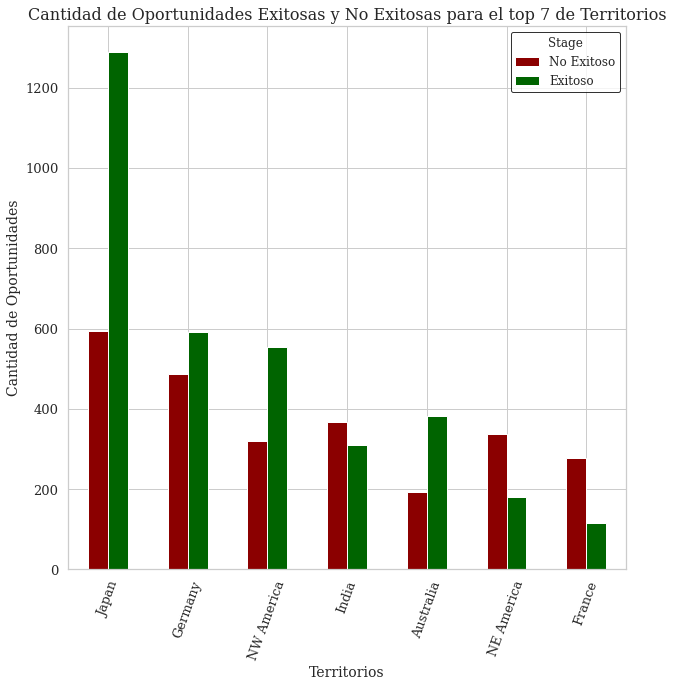

In [38]:
grafico=top7_territorios.plot(kind='bar',color=['darkred','darkgreen'],fontsize=13,figsize=(10,10),rot=70)
grafico.set_title("Cantidad de Oportunidades Exitosas y No Exitosas para el top 7 de Territorios",fontsize=16)
grafico.set_xlabel("Territorios",fontsize=14)
grafico.set_ylabel("Cantidad de Oportunidades",fontsize=14)
leyenda=plt.legend(['No Exitoso','Exitoso'],fontsize=12,title='Stage',frameon=True,facecolor='white',edgecolor='black')
leyenda.get_frame().set_linewidth(1.0)
plt.savefig('graficos/13.png');

* En este gráfico se aprecia que, dentro del Top 7, los tres primeros Territorios con mayor cantidad de oportunidades y Australia presentan una mayor cantidad de casos Exitosos que no Exitosos. Destacándose Japón con una cantidad de casos Exitosos de más del doble que no Exitosos.

* Si prestamos atención un poco más al gráfico nos damos cuenta de que, si quisiéramos listar por ejemplo los dos países (en cantidad de Oportunidades) más exitosos, estos serían: Japón, Germany. Igualmente si quisiéramos listar los dos países menos exitosos (en cantidad de Oportunidades) nuevamente éstos serían: Japón, Germany. Esto pasa porque estamos analizando cantidades absolutas, con lo cual, para poder sacar mejores conclusiones sobre dichos Territorios sería más conveniente realizar un análisis proporcional (relativo) que contemple por ejemplo la cantidad de casos Exitosos sobre el total de casos para cada Territorio y luego sí listar esos 7 Territorios con mejor Ratio Total.


In [39]:
territorio_oprtunidades = pd.pivot_table(df_territorio, values='veces', index=['Territory'],columns=['Stage'], aggfunc=np.sum, fill_value=0).reset_index()
territorio_oprtunidades=territorio_oprtunidades.fillna(0)
territorio_oprtunidades['Total_Oportunidades'] = territorio_oprtunidades['Closed Lost']+ territorio_oprtunidades['Closed Won']
territorio_oprtunidades['Ratio_Oportunidades_exitosas'] = territorio_oprtunidades['Closed Won']/territorio_oprtunidades['Total_Oportunidades']
territorio_oprtunidades.head()

Stage,Territory,Closed Lost,Closed Won,Total_Oportunidades,Ratio_Oportunidades_exitosas
0,Albania,2,0,2,0.000000
1,Arabia Saudita,7,6,13,0.461538
2,Armenia,1,0,1,0.000000
3,Australia,194,383,577,0.663778
4,Austria,14,58,72,0.805556


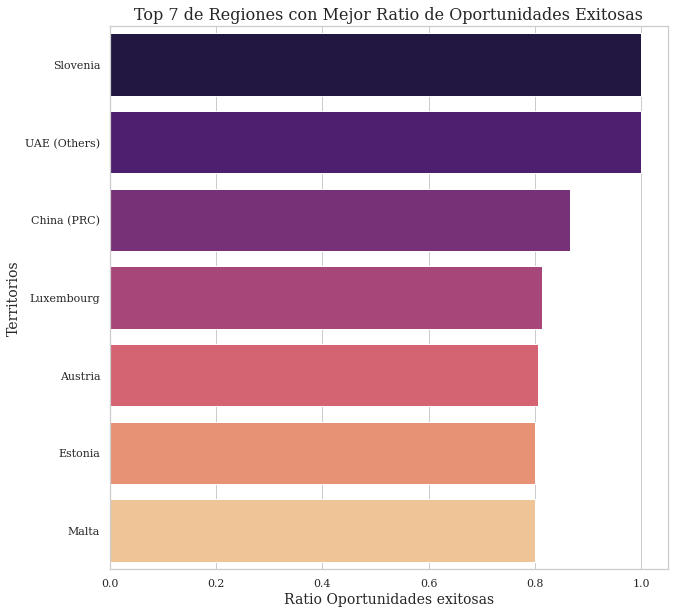

In [48]:
target = territorio_oprtunidades.nlargest(7,'Ratio_Oportunidades_exitosas')
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=target.Ratio_Oportunidades_exitosas,y=target.Territory,palette="magma")
grafico_top_key.set_title("Top 7 de Regiones con Mejor Ratio de Oportunidades Exitosas",fontsize=16)
grafico_top_key.set_xlabel("Ratio Oportunidades exitosas",fontsize=14)
grafico_top_key.set_ylabel("Territorios",fontsize=14);
plt.savefig('graficos/14.png');

* Además para que este análisis no caiga en el problema de la ecuación más paligrosa del mundo, debemos tomar ciertas restricciones, como por ejemplo que en ese Top 7 de mejores Ratios tengamos Territorios con una cantidad de Oportunidades mayor al 1,5% del Total de Oportunidades que presenta la empresa.

In [49]:
territorio_oprtunidades.Total_Oportunidades.sum()*0.015

138.345

* Ahora  filtramos los casos bajo las restricciones pedidas

In [50]:
territorio_oprtunidades=territorio_oprtunidades.loc[territorio_oprtunidades['Total_Oportunidades']>139]

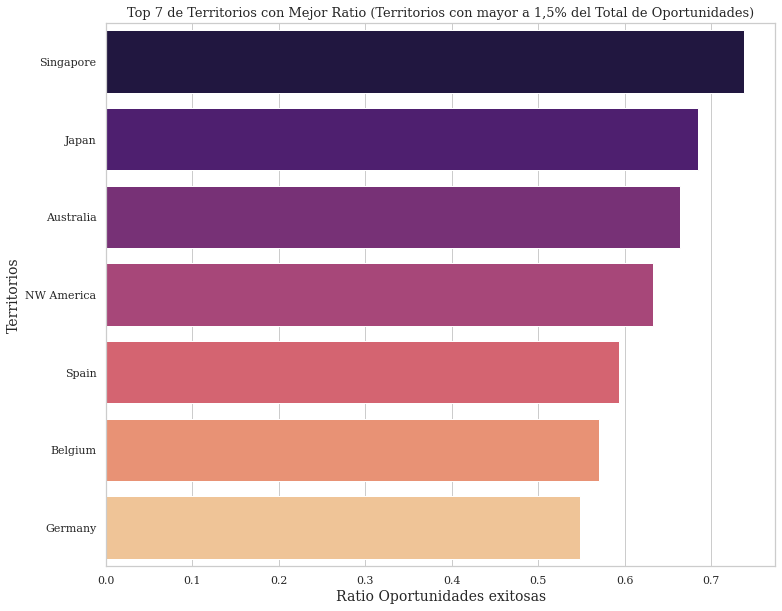

In [51]:
target = territorio_oprtunidades.nlargest(7,'Ratio_Oportunidades_exitosas')
plt.subplots(figsize=(12,10))
grafico_top_key=sns.barplot(x=target.Ratio_Oportunidades_exitosas,y=target.Territory,palette="magma")
grafico_top_key.set_title("Top 7 de Territorios con Mejor Ratio (Territorios con mayor a 1,5% del Total de Oportunidades)",fontsize=13)
grafico_top_key.set_xlabel("Ratio Oportunidades exitosas",fontsize=14)
grafico_top_key.set_ylabel("Territorios",fontsize=14);
plt.savefig('graficos/15.png');

* Se comprueba que nuestras sospechas de que no solamente tener mejor ratio significa ser el más exitoso sino que debemos tener en cuenta además un mínimo de oportunidades para que nuestras comparaciones sean válidas ya que por ejemplo Slovenia si tuvo 2 oportunidades y si ambas fueron exitosas tiene un porcentaje de éxito del 100%. De esta manera vemos Singapore es el más exitoso con un ratio mayor a 0,7, seguidos por Japón, Australia y NW América con un ratio mayor a 0,6 y Spain, Belgium y Germany con un ratio mayor a 0,5.

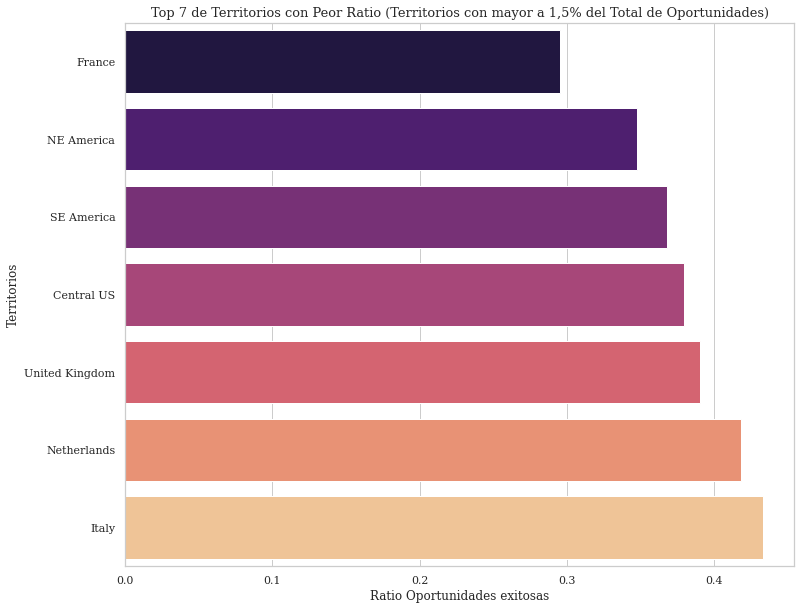

In [53]:
target = territorio_oprtunidades.nsmallest(7,'Ratio_Oportunidades_exitosas')
plt.subplots(figsize=(12,10))
grafico_top_key=sns.barplot(x=target.Ratio_Oportunidades_exitosas,y=target.Territory,palette="magma")
grafico_top_key.set_title("Top 7 de Territorios con Peor Ratio (Territorios con mayor a 1,5% del Total de Oportunidades)",fontsize=13)
grafico_top_key.set_xlabel("Ratio Oportunidades exitosas",fontsize=12)
grafico_top_key.set_ylabel("Territorios",fontsize=12);
plt.savefig('graficos/16.png');

* Es interesante ver que tanto Francia como NE America que pertenecen al top 7 de territorios con mayor cantidad de oportunidades también son las que peor ratio de éxito presentan.

#### Los 7 Territorios con mejor Ratio, como fue su evolución anual?

##### Los 7 Territorios con mejor Ratio y su evolución en cantidad de Oportunidades

In [54]:
target = territorio_oprtunidades.nlargest(7,'Ratio_Oportunidades_exitosas')
#target= target.reset_index()
#target.rename(columns={'index':'Territory','Territory':'Cantidad'},inplace=True)
target

Stage,Territory,Closed Lost,Closed Won,Total_Oportunidades,Ratio_Oportunidades_exitosas
55,Singapore,77,216,293,0.737201
31,Japan,595,1290,1885,0.684350
3,Australia,194,383,577,0.663778
43,NW America,321,553,874,0.632723
61,Spain,65,95,160,0.593750
6,Belgium,77,102,179,0.569832
24,Germany,488,592,1080,0.548148


In [55]:
territorio_year = df_op[['Territory','Año_Oportunidad','Stage']]

In [56]:
top7_territorios=pd.merge(target,territorio_year,on='Territory',how='inner')
top7_territorios['veces']=1

In [57]:
pd.pivot_table(top7_territorios, values='veces', index=['Año_Oportunidad']\
               ,columns=['Territory'], aggfunc=np.sum, fill_value=0)

Territory,Australia,Belgium,Germany,Japan,NW America,Singapore,Spain
Año_Oportunidad,,,,,,,
2014,0,0,1,0,6,0,0
2015,8,1,26,126,79,2,6
2016,131,30,195,646,171,70,41
2017,359,89,428,714,350,112,75
2018,79,59,430,399,268,109,38


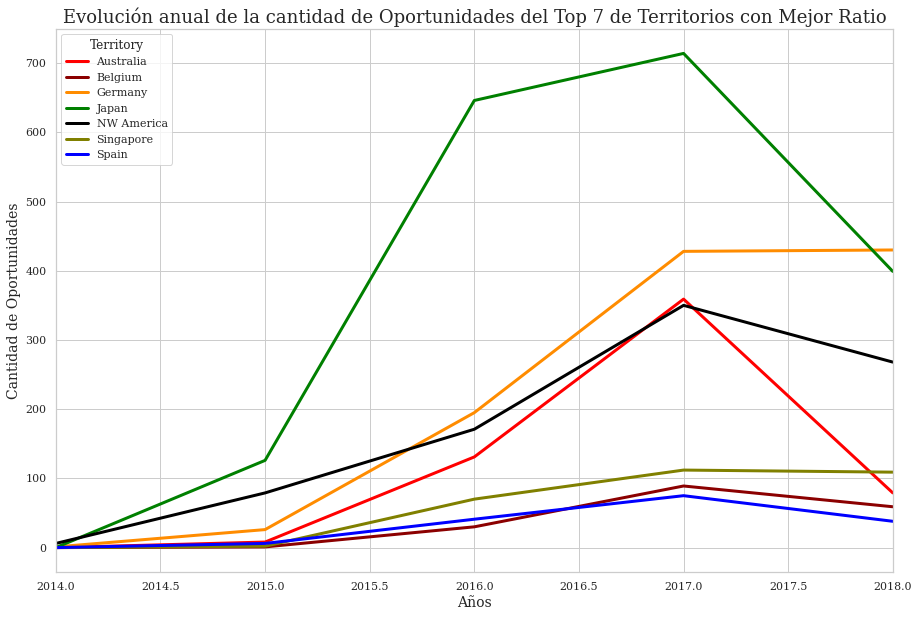

In [58]:
grafico=pd.pivot_table(top7_territorios, values='veces', index=['Año_Oportunidad']\
               ,columns=['Territory'], aggfunc=np.sum, fill_value=0).plot(figsize=(15,10),\
                color=['red','darkred','darkorange','green','black','olive','blue'],linewidth=3);
grafico.set_title("Evolución anual de la cantidad de Oportunidades del Top 7 de Territorios con Mejor Ratio",fontsize=18)
plt.xlim(2014,2018)
grafico.set_xlabel("Años",fontsize=14)
grafico.set_ylabel("Cantidad de Oportunidades",fontsize=14);
plt.savefig('graficos/17.png');

* En este gráfico vemos que la mayoría de los territorios con mejor ratio presentan un crecimiento sostenido de 2015 a 2017, destacándose Japón como el de mayor incremento (notar que la evolución temporal de oportunidades de Japón es prácticamente la misma que la analizada anteriormente en el apartado regiones para Asia Pacífico, mostrando la preponderancia de este territorio en dicha región). Luego de 2017 a 2018 se aprecia una caída en cantidad de oportunidades en casi todos los territorios salvo Singapore y Germany que presentan un amesetamiento. También algo interesante es ver como poco antes del 2018 Germany para a ser el territorio con mayor cantidad de oportunidades.

#### Los 7 Territorios con mejor Ratio y la evolución temporal de su ratio.

In [59]:
top7_territorios_year=pd.pivot_table(top7_territorios, values='veces', index=['Año_Oportunidad','Territory']\
               ,columns=['Stage'], aggfunc=np.sum, fill_value=0)

In [60]:
top7_territorios_year['Total_Oportunidades']=top7_territorios_year['Closed Lost'] + top7_territorios_year['Closed Won']
top7_territorios_year['Ratio_Oportunidades_exitosas'] = top7_territorios_year['Closed Won']/top7_territorios_year['Total_Oportunidades']
top7_territorios_year

Stage                       Closed Lost  Closed Won  Total_Oportunidades  \
Año_Oportunidad Territory                                                  
2014            Germany               0           1                    1   
                NW America            3           3                    6   
2015            Australia             7           1                    8   
                Belgium               1           0                    1   
                Germany              18           8                   26   
                Japan                77          49                  126   
                NW America           65          14                   79   
                Singapore             2           0                    2   
                Spain                 5           1                    6   
2016            Australia            29         102                  131   
                Belgium              14          16                   30   
                Germany             100          95                  195   
                Japan               286         360                  646   
                NW America           74          97                  171   
                Singapore            34          36                   70   
                Spain                16          25                   41   
2017            Australia           114         245                  359   
                Belgium              38          51                   89   
                Germany             175         253                  428   
                Japan               149         565                  714   
                NW America          122         228                  350   
                Singapore            29          83                  112   
                Spain                25          50                   75   
2018            Australia            44          35                   79   
                Belgium              24          35                   59   
                Germany             195         235                  430   
                Japan                83         316                  399   
                NW America           57         211                  268   
                Singapore            12          97                  109   
                Spain                19          19                   38   

Stage                       Ratio_Oportunidades_exitosas  
Año_Oportunidad Territory                                 
2014            Germany                         1.000000  
                NW America                      0.500000  
2015            Australia                       0.125000  
                Belgium                         0.000000  
                Germany                         0.307692  
                Japan                           0.388889  
                NW America                      0.177215  
                Singapore                       0.000000  
                Spain                           0.166667  
2016            Australia                       0.778626  
                Belgium                         0.533333  
                Germany                         0.487179  
                Japan                           0.557276  
                NW America                      0.567251  
                Singapore                       0.514286  
                Spain                           0.609756  
2017            Australia                       0.682451  
                Belgium                         0.573034  
                Germany                         0.591121  
                Japan                           0.791317  
                NW America                      0.651429  
                Singapore                       0.741071  
                Spain                           0.666667  
2018            Australia                       0.443038  
                Belgium          

In [61]:
top7_territorios_year = top7_territorios_year.reset_index()
top7_territorios_year.tail(12)

Stage,Año_Oportunidad,Territory,Closed Lost,Closed Won,Total_Oportunidades,Ratio_Oportunidades_exitosas
18,2017,Germany,175,253,428,0.591121
19,2017,Japan,149,565,714,0.791317
20,2017,NW America,122,228,350,0.651429
21,2017,Singapore,29,83,112,0.741071
22,2017,Spain,25,50,75,0.666667
23,2018,Australia,44,35,79,0.443038
24,2018,Belgium,24,35,59,0.593220
25,2018,Germany,195,235,430,0.546512
26,2018,Japan,83,316,399,0.791980
27,2018,NW America,57,211,268,0.787313


In [62]:
pd.pivot_table(top7_territorios_year, values='Ratio_Oportunidades_exitosas', index=['Año_Oportunidad']\
               ,columns=['Territory'], aggfunc=np.sum, fill_value=0)

Territory,Australia,Belgium,Germany,Japan,NW America,Singapore,Spain
Año_Oportunidad,,,,,,,
2014,0.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.000000
2015,0.125000,0.000000,0.307692,0.388889,0.177215,0.000000,0.166667
2016,0.778626,0.533333,0.487179,0.557276,0.567251,0.514286,0.609756
2017,0.682451,0.573034,0.591121,0.791317,0.651429,0.741071,0.666667
2018,0.443038,0.593220,0.546512,0.791980,0.787313,0.889908,0.500000


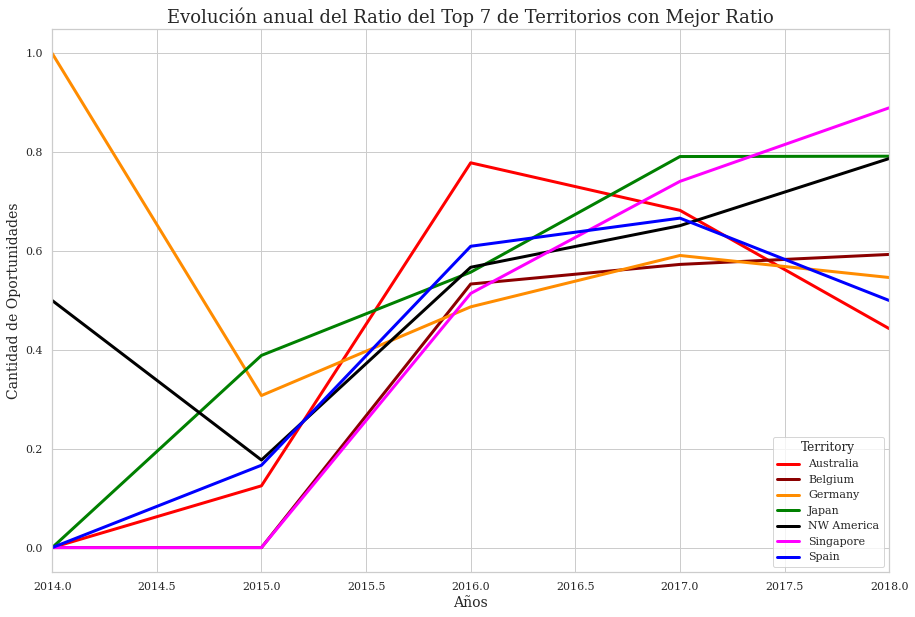

In [64]:
grafico=pd.pivot_table(top7_territorios_year, values='Ratio_Oportunidades_exitosas', index=['Año_Oportunidad']\
               ,columns=['Territory'], aggfunc=np.sum, fill_value=0).plot(figsize=(15,10),\
                color=['red','darkred','darkorange','green','black','magenta','blue'],linewidth=3);
grafico.set_title("Evolución anual del Ratio del Top 7 de Territorios con Mejor Ratio",fontsize=18)
plt.xlim(2014,2018,1)
grafico.set_xlabel("Años",fontsize=14)
grafico.set_ylabel("Cantidad de Oportunidades",fontsize=14);
plt.savefig('graficos/18.png');

* Notar cómo Singapore antes de la mitad del 2017 pasa a ser el territorio con mejor ratio superando a Japón que de 2017 a 2018 muestra un amesetamiento en su ratio y que también está próximo a ser superado por NW América que muestra una tendencia favorable en su ratio desde 2017.

## 5. Estaciones del año

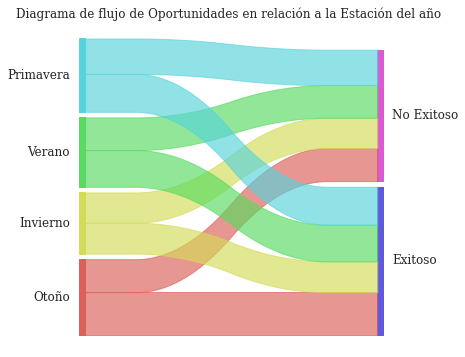

In [65]:
# Filtro primeramente los valores correspondiente a los 2 Hemisferios con los que cuento información(filtro casos nulos)
est = df_op.loc[(df_op['Estación']!='None') & (df_op['Estación'].notnull()),:].copy()
sankey.sankey(est['Estación'],est['Oportunidad'],aspect=20, fontsize=12)
plt.title('Diagrama de flujo de Oportunidades en relación a la Estación del año ',fontsize=12);
plt.savefig('graficos/19.png');

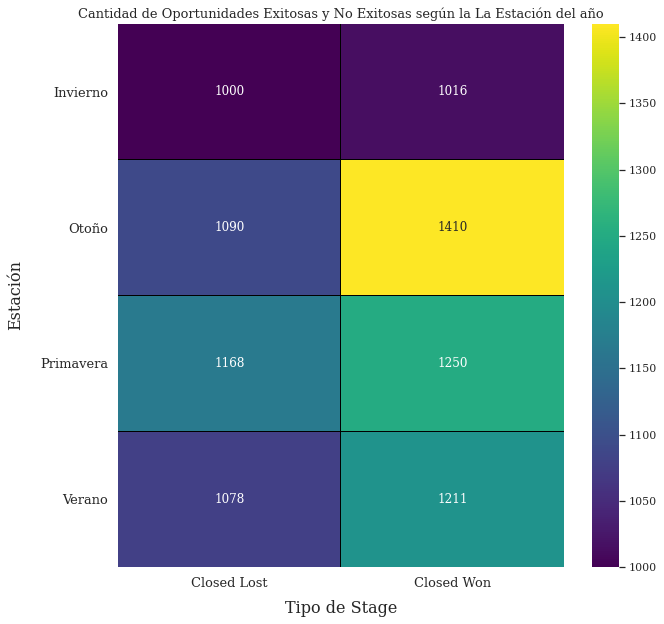

In [66]:
est['veces'] = 1
mi_map=pd.crosstab(est['Estación'], est['Stage'],values=est.veces,aggfunc=np.sum)
fig, ax = plt.subplots(figsize=(10,10))
g = sns.heatmap(mi_map, cmap="viridis", ax=ax, linewidths=0.005, linecolor='black',annot=True,fmt='g')
g.set_title("Cantidad de Oportunidades Exitosas y No Exitosas según la La Estación del año", fontsize=13)
g.set_xlabel("Tipo de Stage", fontsize=16, labelpad=10)
g.set_ylabel("Estación", fontsize=16, labelpad=16, rotation=90)
g.set_xticklabels(g.get_xticklabels(), fontsize=13)
g.set_yticklabels(g.get_yticklabels(), fontsize=13, rotation=0)
g.title.set_position([0.5, 1.05]);
plt.savefig('graficos/20.png');
plt.show()

* Respecto a las estaciones del año vemos que las estaciones Otoño y Primavera se destacan como las que mayor cantidad de oportunidades presentan, siendo Otoño la más popular y mostrando además ser la que presenta mayores oportunidades exitosas con un 57% frente a un 53% de Verano, 51% en Primavera y un 50% en invierno.

## 6. Toneladas de Refrigeración

In [68]:
mi_df=df.groupby(['Opportunity_ID','Region','Estación','Stage'], as_index=False)['TRF'].count()[['Opportunity_ID','Region','Estación','Stage']]
mi_df_trf=df.groupby(['Opportunity_ID'], as_index=False)['TRF'].sum()

In [69]:
mi_df_trf.head()

,Opportunity_ID,TRF
0,0,10
1,1,0
2,2,0
3,3,14
4,4,25


In [70]:
# Si no pongo el +1 caigo en casos de calcular log(0)
mi_df_trf["TRF_log"] = np.log(mi_df_trf["TRF"]+1)

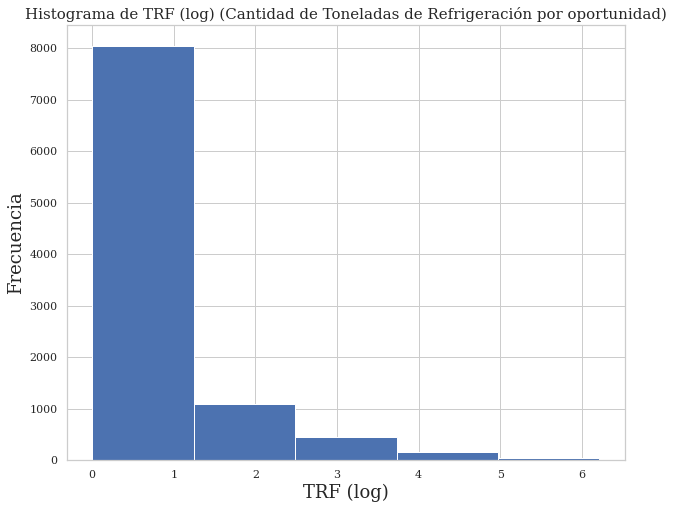

In [71]:
g= mi_df_trf.TRF_log.plot(kind='hist', bins=5,figsize=(10,8))
g.set_title("Histograma de TRF (log) (Cantidad de Toneladas de Refrigeración por oportunidad)", fontsize=15)
g.set_xlabel("TRF (log)",fontsize=18)
g.set_ylabel("Frecuencia", fontsize=18);
plt.savefig('graficos/21.png');

In [72]:
# Junto todo para graficarlo
df_final=pd.merge(mi_df,mi_df_trf,on='Opportunity_ID')
df_final = df_final.loc[(df_final['Stage']!='Proposal') & (df_final['Stage']!='Negotiation') & (df_final['Stage']!='Qualification'),:]

In [73]:
df_final['Toneladas Ref']=' '
df_final.loc[df_final['TRF']<=0.5,'Toneladas Ref']='Menor a 0,5 Toneladas de Refrigeración'
df_final.loc[(df_final['TRF']>0.5) & (df_final['TRF']<5),'Toneladas Ref']='Entre 0,5 y 5 Toneladas de Refrigeración'
df_final.loc[df_final['TRF']>=5,'Toneladas Ref']='Mayor a 5 Toneladas de Refrigeración'

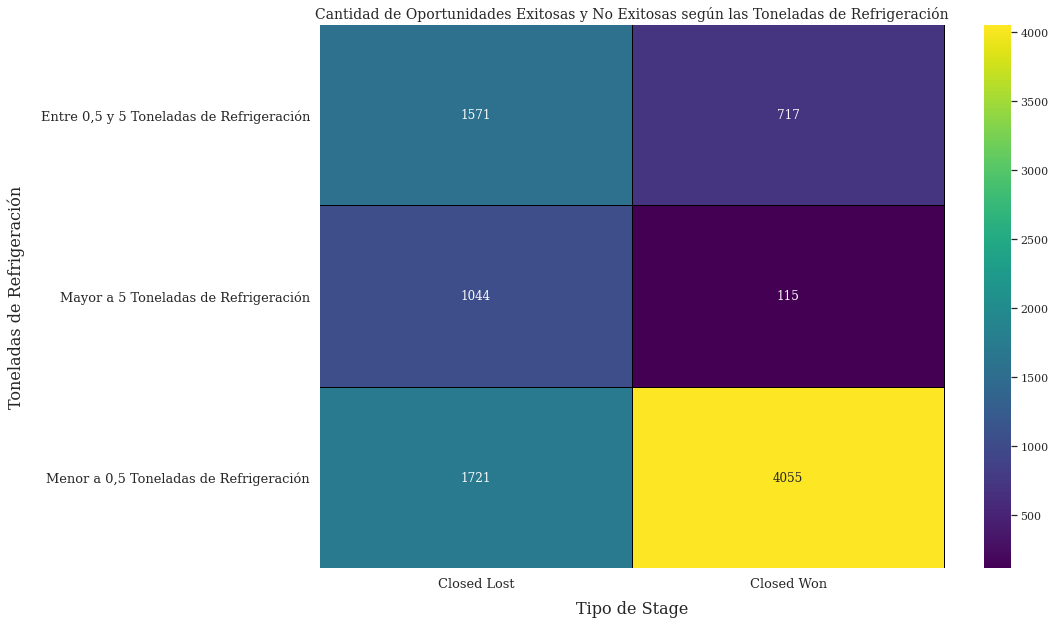

In [77]:
df_final['veces'] = 1
mi_map=pd.crosstab(df_final['Toneladas Ref'], df_final['Stage'],values=df_final.veces,aggfunc=np.sum)
fig, ax = plt.subplots(figsize=(14,10))
g = sns.heatmap(mi_map, cmap="viridis", ax=ax, linewidths=0.005, linecolor='black',annot=True,fmt='g')
g.set_title("Cantidad de Oportunidades Exitosas y No Exitosas según las Toneladas de Refrigeración", fontsize=14)
g.set_xlabel("Tipo de Stage", fontsize=16, labelpad=10)
g.set_ylabel("Toneladas de Refrigeración", fontsize=16, labelpad=16, rotation=90)
g.set_xticklabels(g.get_xticklabels(), fontsize=13)
g.set_yticklabels(g.get_yticklabels(), fontsize=13, rotation=0)
g.title.set_position([0.5, 1.05]);
plt.savefig('graficos/22.png');
plt.show()

* Se observa que las oportunidades se dan mayormente para valores menores a 0,5 toneladas de refrigeración. El éxito de las oportunidades va disminuyendo conforme aumentan las toneladas de refrigeración. 

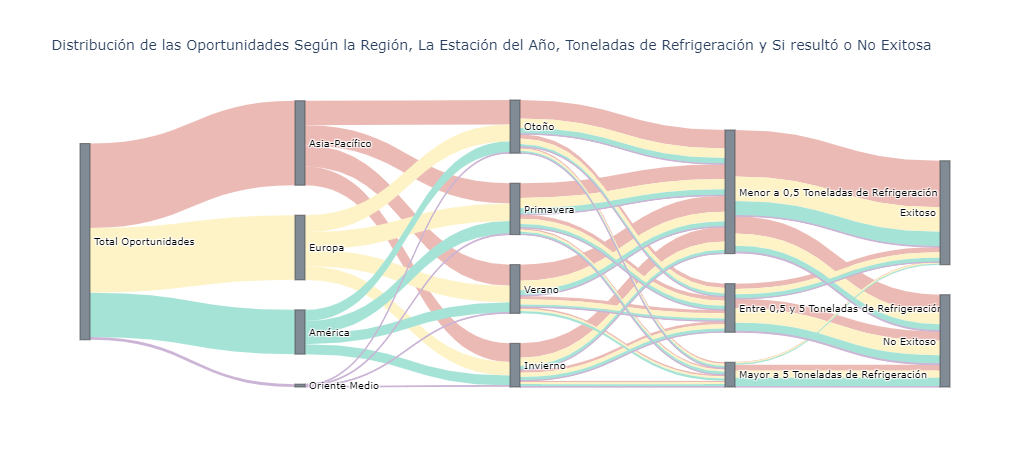

<Figure size 432x288 with 0 Axes>

In [436]:
source = [0, 0, 0, 0,       # Total Oportunidades(va hacia 4 regiones osea a los target 1,2,3,4)
          1, 1, 1, 1,       
          2, 2, 2, 2,           
          3, 3, 3, 3,  
          4, 4, 4, 4,
          5, 5, 5,             
          6, 6, 6,
          7, 7, 7,
          8, 8, 8,
          5, 5, 5,             
          6, 6, 6,
          7, 7, 7,
          8, 8, 8,
          5, 5, 5,             
          6, 6, 6,
          7, 7, 7,
          8, 8, 8,
          5, 5, 5,             
          6, 6, 6,
          7, 7, 7,
          8, 8, 8,
          9, 9,# De acá
          10, 10, 
          11, 11,##
          9, 9,
          10, 10,
          11, 11,
          9, 9,
          10, 10, 
          11, 11,
          9, 9,
          10, 10,
          11, 11,#Hasta acá es A-P
       
         ]          

target = [1, 2, 3, 4, 
          5, 6 , 7, 8, 
          5, 6 , 7, 8,
          5, 6 , 7, 8,
          5, 6 , 7, 8,
          9, 10, 11,
          9, 10, 11, 
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          9, 10, 11,
          12,13,# De aca 
          12,13,
          12,13,
          12,13,
          12,13,
          12,13,
          12,13,
          12,13,
          12,13,
          12,13,
          12,13,
          12,13, #Hasta aca es A-P
           ]

value = [3968, 3040, 2080, 135, # Asia-Pacífico,Europa,America,Oriente Medio
         874,1148,953, 993, # (Asia-Pacífico y Invierno),(Asia-Pacífico y Otoño),(Asia-Pacífico y Primavera),(Asia-Pacífico y Verano)
         641, 797, 823, 779, # (Europa y Invierno),(Europa y Otoño),(Europa y Primavera),(Europa y Verano)
         468, 525, 605, 482, # (America y Invierno),(America y Otoño),(America y Primavera),(America y Verano)
         33, 30, 37, 35, # (Oriente Medio y Invierno),(Oriente Medio y Otoño),(Oriente Medio y Primavera),(Asia-Pacífico y Verano)
         133, 64, 677, #(Asia-Pacífico ,Invierno) y Sus tres correspondientes TRF
         204, 74, 870, #(Asia-Pacífico ,Otoño) y Sus tres correspondientes TR
         192, 70, 691, #(Asia-Pacífico ,Primavera) y Sus tres correspondientes TR
         155, 80, 758, #(Asia-Pacífico ,Verano) y Sus tres correspondientes TR
         199, 94, 384, #(Europa,Invierno) y Sus tres correspondientes TRF
         255, 100, 442, #(Europa,Otoño) y Sus tres correspondientes TRF
         244, 97, 482, #(Europa,Primavera) y Sus tres correspondientes TRF
         241, 88, 450,#(Europa,Verano) y Sus tres correspondientes TRF
         167, 122, 179, #(America,Invierno) y Sus tres correspondientes TRF
         139, 109, 277, #(America,Otoño) y Sus tres correspondientes TRF
         184, 134, 287, #(America,Primavera) y Sus tres correspondientes TRF
         122, 113, 247,#(America,Verano) y Sus tres correspondientes TRF
         15, 8, 10, #(Oriente Medio,Invierno) y Sus tres correspondientes TRF
         8, 2, 20, #(Oriente Medio,Otoño) y Sus tres correspondientes TRF
         12, 8, 17,#(Oriente Medio,Primavera) y Sus tres correspondientes TRF
         14, 0, 21,#(Oriente Medio,Verano) y Sus tres correspondientes TRF
         438, 246, ############ De acá Asia-Pacífico
         274, 14,      
         811,2185,
         684, 255,
         334, 45,
         572, 1150,
         403, 209,
         419, 59,
         298, 692,
         45, 4,
         18, 0,
         40, 28,
        ]

label = ['Total Oportunidades',
         'Asia-Pacífico',
         'Europa', 
         'América',
         'Oriente Medio',
         'Invierno', 
         'Otoño', 
         'Primavera', 
         'Verano',
         'Entre 0,5 y 5 Toneladas de Refrigeración',
         'Mayor a 5 Toneladas de Refrigeración',
         'Menor a 0,5 Toneladas de Refrigeración',
         'No Exitoso',
         'Exitoso',
         ]

color_node = [
'#808B96', 
'#808B96', '#808B96', '#808B96', '#808B96',
'#808B96', '#808B96', '#808B96', '#808B96',
'#808B96','#808B96','#808B96',
'#808B96','#808B96']
color_link = [
'#EBBAB5', '#FEF3C7', '#A6E3D7', '#CBB4D5', #Rojo, #Amarillo, #Verde, #Lila
'#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5',  
'#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', 
'#A6E3D7', '#A6E3D7', '#A6E3D7', '#A6E3D7', 
'#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5',
'#EBBAB5', '#EBBAB5', '#EBBAB5',
'#EBBAB5', '#EBBAB5', '#EBBAB5',
'#EBBAB5', '#EBBAB5', '#EBBAB5',
'#EBBAB5', '#EBBAB5', '#EBBAB5',
'#FEF3C7', '#FEF3C7','#FEF3C7',
'#FEF3C7', '#FEF3C7','#FEF3C7',
'#FEF3C7', '#FEF3C7','#FEF3C7',
'#FEF3C7', '#FEF3C7','#FEF3C7',
'#A6E3D7', '#A6E3D7','#A6E3D7',
'#A6E3D7', '#A6E3D7','#A6E3D7',
'#A6E3D7', '#A6E3D7','#A6E3D7',
'#A6E3D7', '#A6E3D7','#A6E3D7',
'#CBB4D5', '#CBB4D5', '#CBB4D5',
'#CBB4D5', '#CBB4D5', '#CBB4D5',
'#CBB4D5', '#CBB4D5', '#CBB4D5',
'#CBB4D5', '#CBB4D5', '#CBB4D5',
'#EBBAB5','#EBBAB5','#EBBAB5','#EBBAB5','#EBBAB5','#EBBAB5',
'#FEF3C7','#FEF3C7','#FEF3C7','#FEF3C7','#FEF3C7','#FEF3C7',
'#A6E3D7','#A6E3D7','#A6E3D7','#A6E3D7','#A6E3D7','#A6E3D7',
'#CBB4D5','#CBB4D5','#CBB4D5','#CBB4D5','#CBB4D5','#CBB4D5',
]

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color = color_link)
node = dict(label = label, pad=30, thickness=10, color = color_node)
data = go.Sankey(link = link, node=node)
# plot
fig = go.Figure(data)
fig.update_layout(title_text="Distribución de las Oportunidades Según la Región, La Estación del Año, Toneladas de Refrigeración y Si resultó o No Exitosa ", font_size=10)
fig.show()

* Se observa que las distribuciones de oportunidades son bastante similares para cada estación, destacándose otoño en Asia Pacífico con un mayor flujo. También se aprecia que la mayoría de las regiones optan por oportunidades menores a 0,5 Toneladas de refrigeración y que además esta elección se traduce en una mayor cantidad de casos exitosos que no exitosos, a medida que aumentan las toneladas de refrigeración las oportunidades aumentan su flujo hacia casos no exitosos.

## Vendedores Responsables de la Oportunidad

In [76]:
df_ven=df_op[['Opportunity_Owner','Stage']].copy()
df_ven['veces'] = 1
#df_ven = df_ven.loc[df_ven['Territory']!='None',:]

In [77]:
ven_oprtunidades = pd.pivot_table(df_ven, values='veces', index=['Opportunity_Owner'],columns=['Stage'], aggfunc=np.sum, fill_value=0).reset_index()
ven_oprtunidades=ven_oprtunidades.fillna(0)
ven_oprtunidades['Total_Oportunidades'] = ven_oprtunidades['Closed Lost']+ ven_oprtunidades['Closed Won']
ven_oprtunidades['Ratio_Oportunidades_exitosas'] = ven_oprtunidades['Closed Won']/ven_oprtunidades['Total_Oportunidades']
ven_oprtunidades.head()

Stage,Opportunity_Owner,Closed Lost,Closed Won,Total_Oportunidades,Ratio_Oportunidades_exitosas
0,Person_Name_0,1,0,1,0.000000
1,Person_Name_10,2,0,2,0.000000
2,Person_Name_11,45,26,71,0.366197
3,Person_Name_12,16,4,20,0.200000
4,Person_Name_13,322,434,756,0.574074


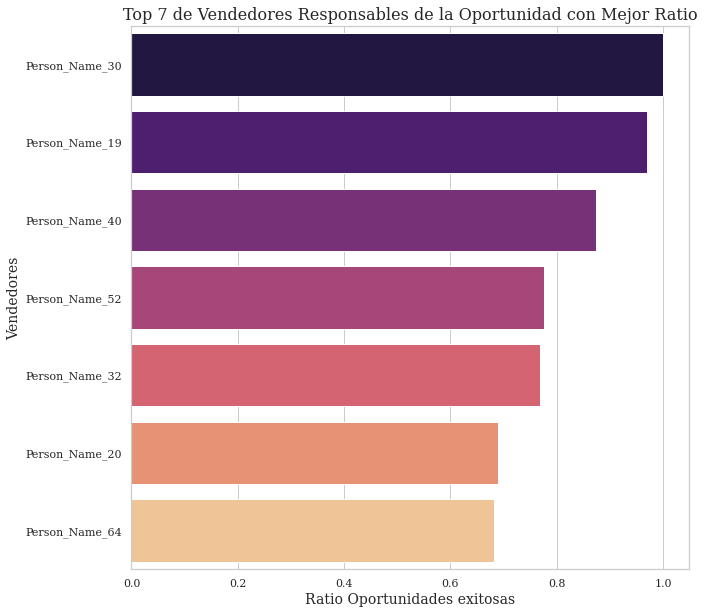

In [78]:
target = ven_oprtunidades.nlargest(7,'Ratio_Oportunidades_exitosas')
plt.subplots(figsize=(10,10))
grafico_top=sns.barplot(x=target.Ratio_Oportunidades_exitosas,y=target.Opportunity_Owner,palette="magma")
grafico_top.set_title("Top 7 de Vendedores Responsables de la Oportunidad con Mejor Ratio",fontsize=16)
grafico_top.set_xlabel("Ratio Oportunidades exitosas",fontsize=14)
grafico_top.set_ylabel("Vendedores",fontsize=14);
plt.savefig('graficos/23.png');

In [79]:
ven_oprtunidades.Total_Oportunidades.sum()*0.01

97.91

In [80]:
ven_oprtunidades=ven_oprtunidades.loc[ven_oprtunidades['Total_Oportunidades']>98]

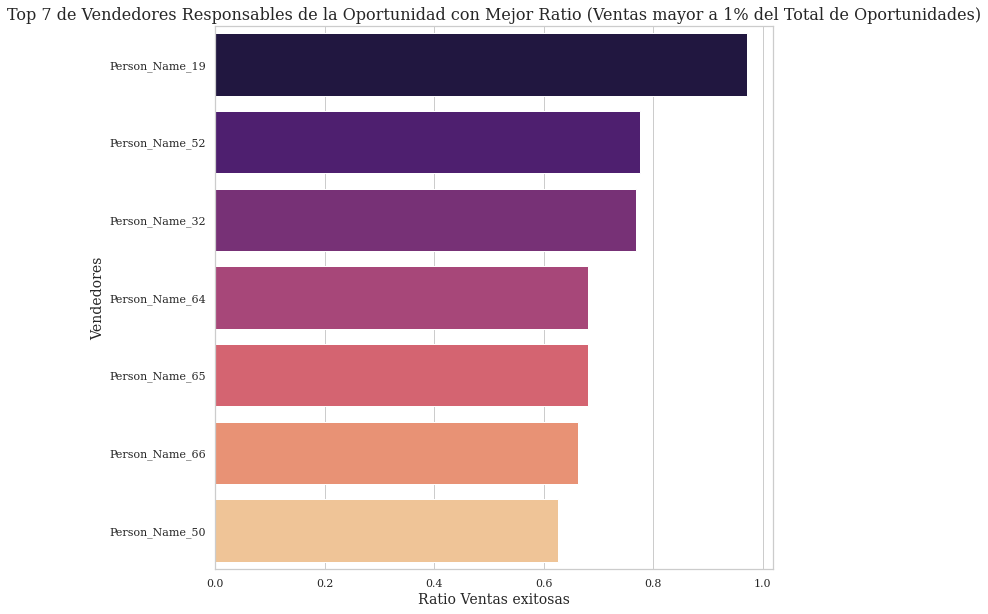

In [81]:
target = ven_oprtunidades.nlargest(7,'Ratio_Oportunidades_exitosas')
plt.subplots(figsize=(10,10))
grafico_top=sns.barplot(x=target.Ratio_Oportunidades_exitosas,y=target.Opportunity_Owner,palette="magma")
grafico_top.set_title("Top 7 de Vendedores Responsables de la Oportunidad con Mejor Ratio (Ventas mayor a 1% del Total de Oportunidades)",fontsize=16)
grafico_top.set_xlabel("Ratio Ventas exitosas",fontsize=14)
grafico_top.set_ylabel("Vendedores",fontsize=14);
plt.savefig('graficos/244.png');

* Se aprecia nuevamente que el vendedor con mejor ratio (Person_Name_30) absoluto no es en realidad el mejor tomando ciertas restricciones, es más ni siquiera está en el top 7 de mejores vendedores. Cabe destacar que el 1% tomado como filtro mínimo de ventas representa unas 100 ventas. Es muy destacable el ratio que presenta el vendedor Person_Name_19 con un ratio altísimo superior al 0,9.

## Nombre del Prodcuto

In [78]:
df_p=df[['Product_Name','Stage']].copy()
df_p['veces'] = 1
df_p = df_p.loc[df_p['Product_Name']!='None',:]

In [79]:
prod = pd.pivot_table(df_p, values='veces', index=['Product_Name'],columns=['Stage'], aggfunc=np.sum, fill_value=0).reset_index()
prod=prod.fillna(0)
prod['Total_Oportunidades'] = prod['Closed Lost']+ prod['Closed Won']
prod['Ratio_Oportunidades_exitosas'] = prod['Closed Won']/prod['Total_Oportunidades']
prod.head()

Stage,Product_Name,Closed Lost,Closed Won,Total_Oportunidades,Ratio_Oportunidades_exitosas
0,Product_Name_0,69,96,165,0.581818
1,Product_Name_1,4,9,13,0.692308
2,Product_Name_10,40,76,116,0.655172
3,Product_Name_100,401,575,976,0.589139
4,Product_Name_101,1,3,4,0.750000


In [80]:
prod=prod.loc[prod['Total_Oportunidades']>100]

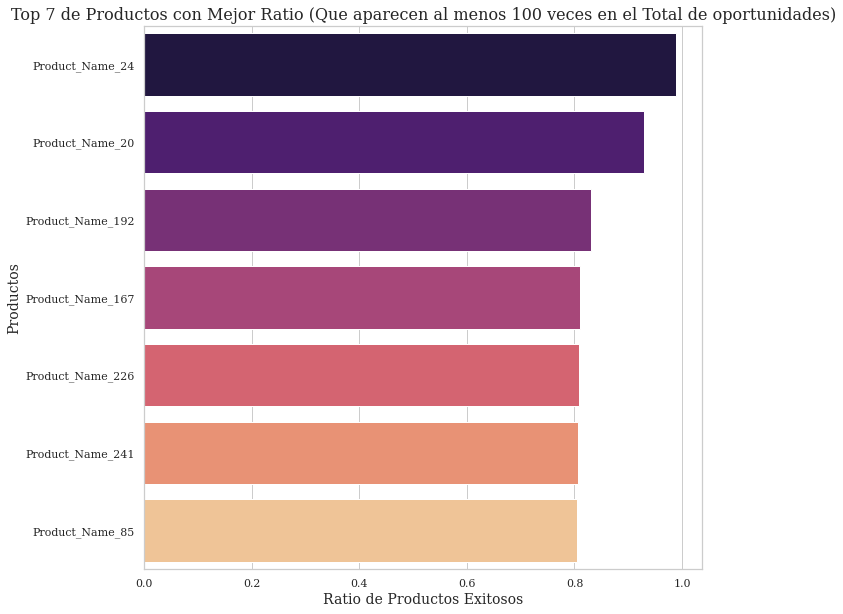

In [81]:
target = prod.nlargest(7,'Ratio_Oportunidades_exitosas')
plt.subplots(figsize=(10,10))
grafico_top=sns.barplot(x=target.Ratio_Oportunidades_exitosas,y=target.Product_Name,palette="magma")
grafico_top.set_title("Top 7 de Productos con Mejor Ratio (Que aparecen al menos 100 veces en el Total de oportunidades)",fontsize=16)
grafico_top.set_xlabel("Ratio de Productos Exitosos",fontsize=14)
grafico_top.set_ylabel("Productos",fontsize=14);
plt.savefig('graficos/25.png');

* En cuanto a los productos podemos destacar al Product_Name_24 con un ratio cercano a 1, Product_Name_20 con ratio mayor a 0,9. Los 5 restantes muestran un interesante ratio mayor o igual a 0,8.

## Cantidad de Items de cada Oportunidad

In [83]:
Op_cant = df.groupby(['Opportunity_ID'], as_index=False)['ID'].count()

In [84]:
Op_cant.sample(8)

,Opportunity_ID,ID
5556,5785,2
5298,5509,1
1800,1884,2
5271,5482,1
4140,4311,1
5744,5995,2
4247,4419,2
8829,9666,2


In [85]:
Op_cant.rename(columns = {'ID': 'Cantidad de Items Asociados'}, inplace = True)
Op_cant.sample(10)

,Opportunity_ID,Cantidad de Items Asociados
2005,2092,1
1826,1912,1
1426,1503,1
8815,9644,1
4510,4690,1
196,200,2
9144,10175,1
6844,7179,1
6647,6958,2
8011,8539,1


In [86]:
df_aux=df.groupby(['Opportunity_ID','Region','Territory','Stage'], as_index=False)['ID'].count()[['Opportunity_ID','Region','Territory','Stage']]
df_aux

,Opportunity_ID,Region,Territory,Stage
0,0,Europa,None,Closed Lost
1,1,Europa,None,Closed Won
2,2,América,NW America,Closed Won
3,3,América,NW America,Closed Lost
4,4,América,NW America,Closed Lost
...,...,...,...,...
9786,12799,Europa,Norway,Closed Won
9787,12800,América,NE America,Closed Lost
9788,12801,Europa,Austria,Closed Won
9789,12802,América,NE America,Closed Lost


In [87]:
df_cant=pd.merge(Op_cant,df_aux,on='Opportunity_ID')
df_cant['Cantidad de Items Asociados'].value_counts()

1     6933
2     1597
3      397
6      264
5      223
4      181
7       99
8       49
9       16
10      12
11       4
12       3
13       3
14       2
26       2
36       2
16       2
18       1
24       1
Name: Cantidad de Items Asociados, dtype: int64

In [88]:
exitosos=df_cant.loc[df_cant["Stage"]=='Closed Won',:]
no_exitosos=df_cant.loc[df_cant["Stage"]=='Closed Lost',:]

In [89]:
df_cant['Cantidad de Items Casos Exitosos'] = exitosos['Cantidad de Items Asociados']
df_cant['Cantidad de Items Casos No Exitosos'] = no_exitosos['Cantidad de Items Asociados']

In [90]:
exito=exitosos['Cantidad de Items Asociados'].value_counts()
no_exito=no_exitosos['Cantidad de Items Asociados'].value_counts()

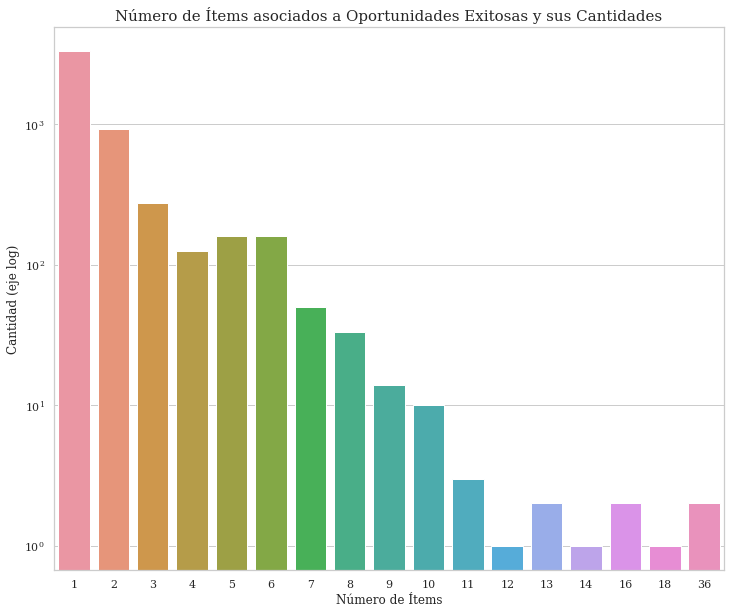

In [91]:
fig, ax = plt.subplots(figsize=(12,10))
g = sns.barplot(y=exito.values, x=exito.index, orient='v')
g.set_title("Número de Ítems asociados a Oportunidades Exitosas y sus Cantidades", fontsize=15)
g.set_xlabel("Número de Ítems", fontsize=12)
g.set_ylabel("Cantidad (eje log)", fontsize=12)
g.set(yscale="log");

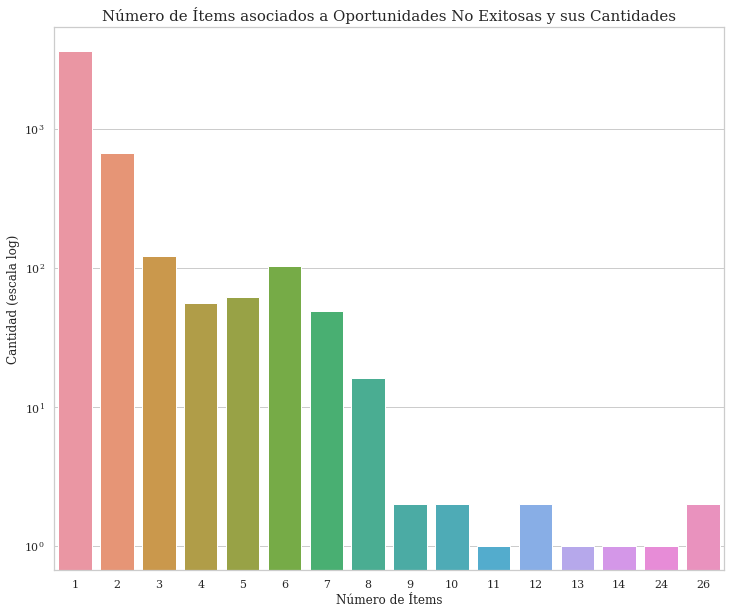

In [92]:
fig, ax = plt.subplots(figsize=(12,10))
g = sns.barplot(y=no_exito.values, x=no_exito.index, orient='v')
g.set_title("Número de Ítems asociados a Oportunidades No Exitosas y sus Cantidades", fontsize=15)
g.set_xlabel("Número de Ítems", fontsize=12)
g.set_ylabel("Cantidad (escala log)", fontsize=12)
g.set(yscale="log");

In [93]:
df_cant=df_cant.fillna(0)
df_cant['Cantidad de Items Casos Exitosos'] = exitosos['Cantidad de Items Asociados']
df_cant['Cantidad de Items Casos No Exitosos'] = no_exitosos['Cantidad de Items Asociados']
exito=exitosos['Cantidad de Items Asociados'].value_counts()
no_exito=no_exitosos['Cantidad de Items Asociados'].value_counts()
df_cant=df_cant.loc[(df_cant['Cantidad de Items Asociados']>0) & (df_cant['Cantidad de Items Asociados']<20),:]
df_cant=df_cant.fillna(0)

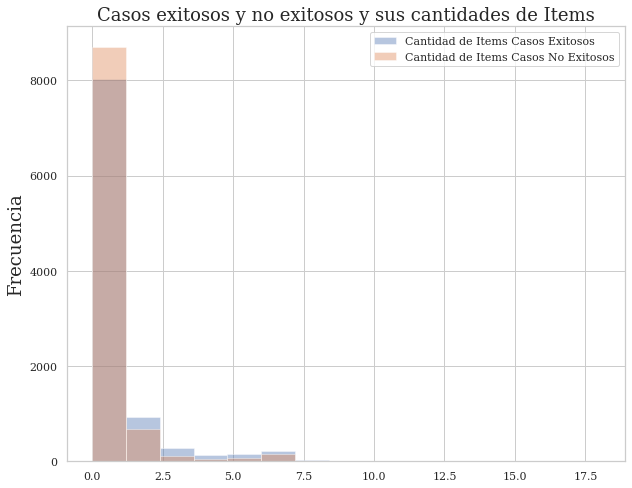

In [94]:
g = df_cant[['Cantidad de Items Casos Exitosos','Cantidad de Items Casos No Exitosos']].plot.hist(bins=15,alpha=0.4,figsize=(10,8))
g.set_title("Casos exitosos y no exitosos y sus cantidades de Items", fontsize=18)
g.set_ylabel("Frecuencia", fontsize=18);


In [405]:
#df_cant.loc[(df_cant['Cantidad de Items Casos Exitosos']<=15) & (df_cant['Cantidad de Items Casos No Exitosos']<=15),:]

In [95]:
df_cant['Cantidad de Items Casos Exitosos'].mean()

0.9429797670141018

In [96]:
df_cant['Cantidad de Items Casos No Exitosos'].mean()

0.7213366033108523

[None]

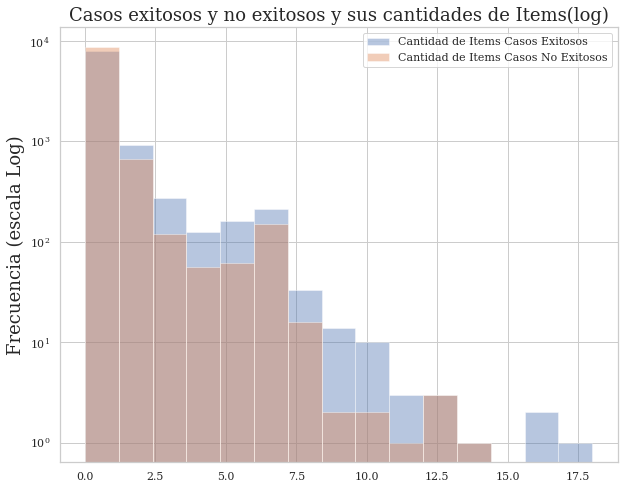

In [97]:
g = df_cant[['Cantidad de Items Casos Exitosos','Cantidad de Items Casos No Exitosos']].plot.hist(bins=15,alpha=0.4,figsize=(10,8))
g.set_title("Casos exitosos y no exitosos y sus cantidades de Items(log)", fontsize=18)
g.set_ylabel("Frecuencia (escala Log)", fontsize=18)
g.set(yscale="log")

### Familia de Productos

In [424]:
df.Product_Family.value_counts().head()

Product_Family_77     1345
Product_Family_133    1137
Product_Family_132     734
Product_Family_100     613
Product_Family_212     599
Name: Product_Family, dtype: int64

In [421]:
df_toneladas=df.groupby(['Region','Product_Family','Stage'], as_index=False).agg({'TRF':'count'})
df_toneladas

,Region,Product_Family,Stage,TRF
0,América,Product_Family_100,Closed Lost,5
1,América,Product_Family_102,Closed Won,2
2,América,Product_Family_110,Closed Lost,2
3,América,Product_Family_110,Closed Won,1
4,América,Product_Family_111,Closed Lost,10
...,...,...,...,...
672,Oriente Medio,Product_Family_85,Closed Lost,4
673,Oriente Medio,Product_Family_85,Closed Won,1
674,Oriente Medio,Product_Family_92,Closed Won,1
675,Oriente Medio,Product_Family_94,Closed Lost,1


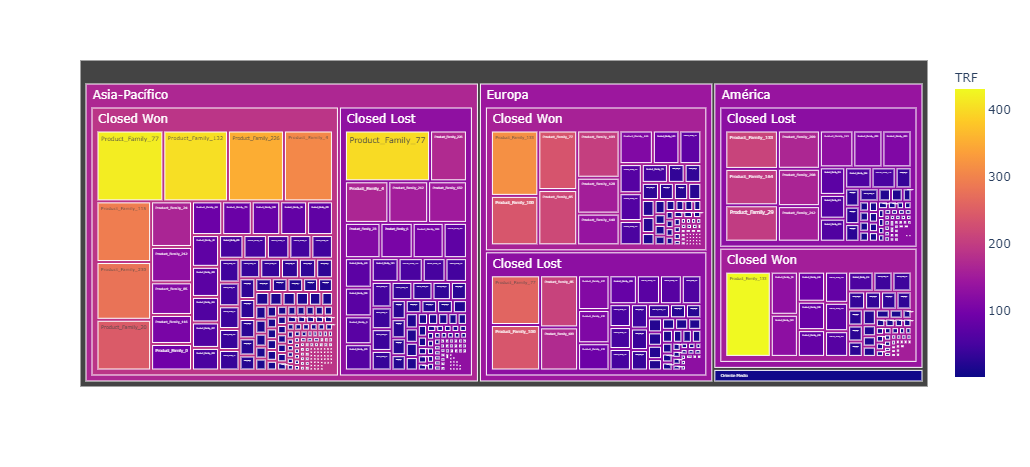

In [422]:
import plotly.express as px
fig = px.treemap(df_toneladas, 
                 path=['Region', 'Stage','Product_Family'], 
                 values='TRF',
                 color='TRF'
                )
fig.show()